# LSTM

## Import Library

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary

from torchtext.vocab import Vectors, GloVe

import nltk
import random

import numpy as np
import matplotlib.pyplot as plt

from utils import train_loop,test_loop

## Check MPS Device for GPU

In [17]:
import torch
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    print('can use GPU')
    
mps_device = torch.device("mps")

can use GPU


## Load Data

In [18]:
def shuffle(label,tokens):
    zipped = list(zip(label,tokens))
    random.shuffle(zipped)
    label, tokens = zip(*zipped)
    return label, tokens

In [28]:
from torchtext.datasets import IMDB
from torchtext.data import get_tokenizer

train_iter = IMDB(split='train')
val_iter = IMDB(split='test')

tokenizer = get_tokenizer("basic_english")

train_tokens = []
val_tokens = []

train_label = []
val_label = []

train_pos_lines = []
train_neg_lines = []

val_pos_lines = []
val_neg_lines = []

for label, line in train_iter:
    if label == 'pos':
        train_pos_lines.append(line)
    else:
        train_neg_lines.append(line)
    train_label.append(label)
    train_tokens.append(tokenizer(line))

for label, line in val_iter:
    if label == 'pos':
        val_pos_lines.append(line)
    else:
        val_neg_lines.append(line)
    val_label.append(label)
    val_tokens.append(tokenizer(line))

train_label, train_tokens = shuffle(train_label,train_tokens)
val_label, val_tokens = shuffle(val_label,val_tokens)

In [29]:
print('the number of train sample : {}'.format(len(train_tokens)))
print('train positive sample      : {}'.format(len(train_pos_lines)))
print('train negative sample      : {}'.format(len(train_neg_lines)))
print('the number of val sample   : {}'.format(len(val_tokens)))
print('val positive sample        : {}'.format(len(val_pos_lines)))
print('val negative sample        : {}'.format(len(val_neg_lines)))

the number of train sample : 25000
train positive sample      : 12500
train negative sample      : 12500
the number of val sample   : 25000
val positive sample        : 12500
val negative sample        : 12500


In [30]:
from nltk import FreqDist

vocab = FreqDist(np.hstack(train_tokens))
print('size of vocab : {}'.format(len(vocab)))

size of vocab : 100682


In [31]:
vocab_size = 100000
vocab = vocab.most_common(vocab_size)
print('size of vocab : {}'.format(len(vocab)))

size of vocab : 100000


In [32]:
word2index = {word[0] : index+2 for index,word in enumerate(vocab)}
word2index['<pad>'] = 1
word2index['<unk>'] = 0

In [33]:
train_encoded = []
for line in train_tokens:
    temp=[]
    for w in line:
        try:
            temp.append(word2index[w])
        except KeyError:
            temp.append(word2index['<unk>'])
    
    train_encoded.append(temp)

train_int_label = []
for label in train_label:
    if label=='pos':
        train_int_label.append([1.0,0.0])
    else:
        train_int_label.append([0.0,1.0])

val_encoded = []
for line in val_tokens:
    temp = []
    for w in line:
        try:
            temp.append(word2index[w])
        except KeyError:
            temp.append(word2index['<unk>'])
    
    val_encoded.append(temp)
            
val_int_label = []
for label in val_label:
    if label=='pos':
        val_int_label.append([1.0,0.0])
    else:
        val_int_label.append([0.0,1.0])


max  length : 2752
min  length : 11
mean length : 270.68748


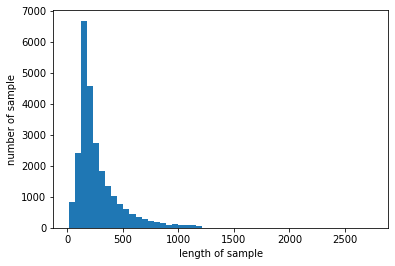

In [34]:
line_length = [len(s) for s in train_tokens]
max_len = max(line_length)
print('max  length : {}'.format(max(line_length)))
print('min  length : {}'.format(min(line_length)))
print('mean length : {}'.format(np.mean(line_length)))
plt.hist(line_length,bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

max  length : 2623
min  length : 8
mean length : 264.63664


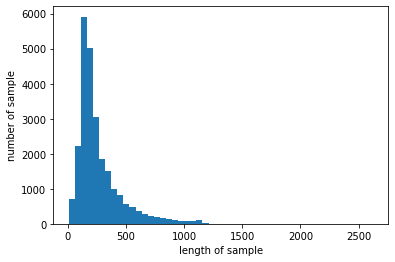

In [26]:
line_length = [len(s) for s in val_tokens]
max_len = max(line_length)
print('max  length : {}'.format(max(line_length)))
print('min  length : {}'.format(min(line_length)))
print('mean length : {}'.format(np.mean(line_length)))
plt.hist(line_length,bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

In [35]:
for line in train_encoded:
    if len(line)< max_len:
        line += [word2index['<pad>']] * (max_len - len(line))

for line in val_encoded:
    if len(line)< max_len:
        line += [word2index['<pad>']] * (max_len - len(line))

max  length : 2752
min  length : 2752
mean length : 2752.0


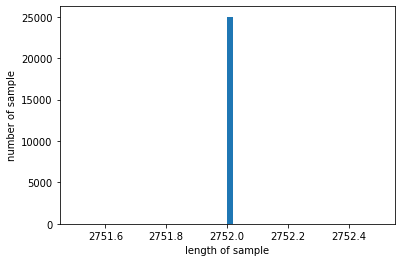

In [36]:
encoded_len = [len(l) for l in train_encoded]
print('max  length : {}'.format(max(encoded_len)))
print('min  length : {}'.format(min(encoded_len)))
print('mean length : {}'.format(np.mean([encoded_len])))
plt.hist(encoded_len,bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

max  length : 2752
min  length : 2752
mean length : 2752.0


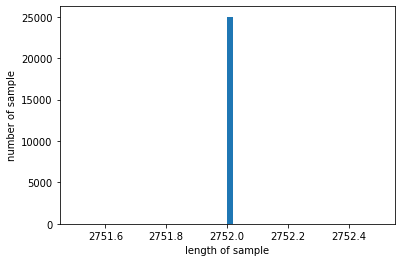

In [37]:
encoded_len = [len(l) for l in val_encoded]
print('max  length : {}'.format(max(encoded_len)))
print('min  length : {}'.format(min(encoded_len)))
print('mean length : {}'.format(np.mean([encoded_len])))
plt.hist(encoded_len,bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

## Simple LSTM

In [38]:
class LSTMClassifier(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, \
        vocab_size, embedding_length=2752):
        super(LSTMClassifier,self).__init__()
        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.lstm = nn.LSTM(input_size=embedding_length,hidden_size=hidden_size)
        self.label = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax()
    
    def forward(self, input_sentence):
        input = self.word_embeddings(input_sentence)
        input = input.permute(1,0,2)
        if self.batch_size:
            h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size),requires_grad=True)
            c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size),requires_grad=True)
        else:
            h_0 = Variable(torch.zeros(1, 16, self.hidden_size),requires_grad=True)
            c_0 = Variable(torch.zeros(1, 16, self.hidden_size),requires_grad=True)
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
        final_output = self.label(final_hidden_state[-1])        
        final_output = self.softmax(final_output)
        
        return final_output

# Define how to Train & Validate

In [39]:
model = LSTMClassifier(batch_size=32,output_size=2,hidden_size=128,vocab_size=100005)
# model.to(mps_device)

In [40]:
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.02,momentum=0.9,weight_decay=0.0005)

In [41]:

def train_model(model, train_tokens, train_int_label, epoch):
    total_epoch_loss = 0
    total_epoch_acc = 0
    # model.train()
    label, train_data = shuffle(train_int_label,train_tokens)
    
    total_batch = len(train_data)//model.batch_size
    best_acc = 0
    for iter in range(total_batch):
        # read_token =  torch.tensor(train_data[iter*model.batch_size:(iter+1)*model.batch_size]).to(device=mps_device)
        # read_label =  torch.tensor(label[iter*model.batch_size:(iter+1)*model.batch_size]).to(device=mps_device)
        read_token =  torch.tensor(train_data[iter*model.batch_size:(iter+1)*model.batch_size])
        read_label =  torch.tensor(label[iter*model.batch_size:(iter+1)*model.batch_size])
        
        pred = torch.tensor(model(read_token)).clone().detach().requires_grad_(True)
        loss = loss_fn(pred, read_label)
        
        num_corrects = (torch.tensor(pred).argmax(1) == torch.tensor(read_label).argmax(1))\
            .type(torch.float).sum().item()
        acc = 100.0 * num_corrects / model.batch_size
        
        if acc > best_acc:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            best_acc = acc
            print('Weights are updated')
        
        if iter % (total_batch//10) ==0:
            print(f'Iter: {iter+1}/{total_batch}\nTraining Loss: {loss:.4f},\
                \nTraining Accuracy: {acc:.2f}%')
            
        total_epoch_loss += loss
        total_epoch_acc += acc
    
    return total_epoch_loss/total_batch, total_epoch_acc/total_batch

In [42]:
def eval_model(model, val_tokens, val_int_label):
    total_epoch_loss = 0
    total_epoch_acc = 0
    # model.eval()
    label, val_data = shuffle(val_int_label,val_tokens)
    with torch.no_grad():
        for idx in range(100):
            # read_token = torch.tensor(val_data[idx*model.batch_size:(idx+1)*model.batch_size]).to(device=mps_device)
            # read_label = torch.tensor(label[idx*model.batch_size:(idx+1)*model.batch_size]).to(device=mps_device)

            read_token = torch.tensor(val_data[idx*model.batch_size:(idx+1)*model.batch_size])
            read_label = torch.tensor(label[idx*model.batch_size:(idx+1)*model.batch_size])

            pred = torch.tensor(model(read_token)).clone().detach().requires_grad_(True)
            loss = loss_fn(pred, read_label)
            
            num_corrects = (pred.argmax(1) == torch.tensor(read_label).argmax(1))\
                .type(torch.float).sum().item()
            acc = 100.0 * num_corrects / model.batch_size
            
            total_epoch_loss += loss
            total_epoch_acc += acc
    
    return total_epoch_loss/100, total_epoch_acc/100
        

# Train

In [43]:
train={}
train['acc'] = []
train['loss'] =[]

val={}
val['acc'] = []
val['loss'] =[]

In [44]:
for epoch in range(epochs):
    print(f'Epoch: {epoch+1:02}')
    train_loss, train_acc = train_model(model,train_encoded,train_int_label,epoch)
    val_loss, val_acc = eval_model(model,val_encoded,val_int_label)
    
    train['loss'].append(train_loss)
    train['acc'].append(train_acc)
    val['loss'].append(val_loss)
    val['acc'].append(val_acc)
    
    print(f'Epoch: {epoch+1:02}\nTrain Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%\
        \nVal Loss: {val_loss:.3f}, Val Acc: {val_acc:.2f}%')

/var/folders/0l/3n3y7jns43l8x_lzc7n9yhqh0000gn/T/ipykernel_72021/1778032943.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_output = self.softmax(final_output)
/var/folders/0l/3n3y7jns43l8x_lzc7n9yhqh0000gn/T/ipykernel_72021/2822885739.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(model(read_token)).clone().detach().requires_grad_(True)
/var/folders/0l/3n3y7jns43l8x_lzc7n9yhqh0000gn/T/ipykernel_72021/2822885739.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_corrects = (torch.tensor(pred).argmax(1) == torch.tensor(read_label).argmax(1))\


Iter: 1/781
Training Loss: 0.6995,                
Training Accuracy: 43.75%
Iter: 79/781
Training Loss: 0.6887,                
Training Accuracy: 56.25%
Iter: 157/781
Training Loss: 0.6941,                
Training Accuracy: 50.00%
Iter: 235/781
Training Loss: 0.7049,                
Training Accuracy: 37.50%
Iter: 313/781
Training Loss: 0.6860,                
Training Accuracy: 59.38%
Iter: 391/781
Training Loss: 0.6887,                
Training Accuracy: 56.25%
Iter: 469/781
Training Loss: 0.7022,                
Training Accuracy: 40.62%
Iter: 547/781
Training Loss: 0.6914,                
Training Accuracy: 53.12%
Iter: 625/781
Training Loss: 0.6968,                
Training Accuracy: 46.88%
Iter: 703/781
Training Loss: 0.6914,                
Training Accuracy: 53.12%
Iter: 781/781
Training Loss: 0.6806,                
Training Accuracy: 65.62%


/var/folders/0l/3n3y7jns43l8x_lzc7n9yhqh0000gn/T/ipykernel_72021/1726177042.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(model(read_token)).clone().detach().requires_grad_(True)
/var/folders/0l/3n3y7jns43l8x_lzc7n9yhqh0000gn/T/ipykernel_72021/1726177042.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_corrects = (pred.argmax(1) == torch.tensor(read_label).argmax(1))\


Epoch: 01
Train Loss: 0.694, Train Acc: 50.01%
        Val Loss: 0.693, Val Acc: 51.38%
Iter: 1/781
Training Loss: 0.6941,                
Training Accuracy: 50.00%
Iter: 79/781
Training Loss: 0.6968,                
Training Accuracy: 46.88%
Iter: 157/781
Training Loss: 0.6941,                
Training Accuracy: 50.00%
Iter: 235/781
Training Loss: 0.6995,                
Training Accuracy: 43.75%
Iter: 313/781
Training Loss: 0.6860,                
Training Accuracy: 59.38%
Iter: 391/781
Training Loss: 0.6968,                
Training Accuracy: 46.88%
Iter: 469/781
Training Loss: 0.7022,                
Training Accuracy: 40.62%
Iter: 547/781
Training Loss: 0.7102,                
Training Accuracy: 31.25%
Iter: 625/781
Training Loss: 0.6887,                
Training Accuracy: 56.25%
Iter: 703/781
Training Loss: 0.6941,                
Training Accuracy: 50.00%
Iter: 781/781
Training Loss: 0.7076,                
Training Accuracy: 34.38%
Epoch: 02
Train Loss: 0.694, Train Acc: 50.00%

: 

: 

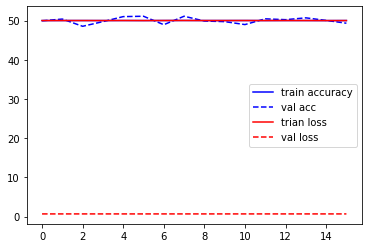

In [ ]:
plt.plot(train['acc'],'-b',label='train accuracy')
plt.plot(val['acc'],'--b',label='val acc')
plt.plot(train['acc'],'-r',label='trian loss')
plt.plot(val['loss'],'--r',label='val loss')
plt.legend()
plt.show()